In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=10):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [20]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 10


"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)


"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [25]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("move_data"):
        imgs, _ = next(iter(train_loader))
        imgs = imgs.to(device)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              move_data         3.14%       1.034ms       100.00%      32.978ms      32.978ms             1  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        62.28%      20.539ms        89.05%      29.366ms      29.366ms             1  
                                               aten::to         1.11%     365.000us        15.27%       5.035ms      13.044us           386  
                                         aten::_to_copy         3.59%       1.184ms        14.27%       4.705ms      18.307us           257  
      

In [27]:
imgs[0].dtype

torch.float32

In [10]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("net"):
                out, mu, logVar = net(imgs)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  net        10.54%       2.949ms       100.00%      27.966ms      27.966ms             1  
                    aten::convolution         0.57%     159.000us        38.69%      10.820ms       2.705ms             4  
                   aten::_convolution         0.54%     151.000us        38.12%      10.661ms       2.665ms             4  
                         aten::conv2d         0.10%      28.000us        24.57%       6.870ms       3.435ms             2  
                         aten::linear         0.56%     156.000us        24.10%       6.740ms       2.247ms             3  
        

In [11]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("calc_loss"):
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     calc_loss        31.70%       2.995ms       100.00%       9.448ms       9.448ms             1  
                     aten::pow        21.87%       2.066ms        21.93%       2.072ms       2.072ms             1  
    aten::binary_cross_entropy        14.07%       1.329ms        16.96%       1.602ms       1.602ms             1  
                     aten::sum        13.46%       1.272ms        13.54%       1.279ms     639.500us             2  
                    aten::rsub         5.32%     503.000us        12.48%       1.179ms       1.179ms             1  
                     aten::sub         7.15%     676.000us      

C:\Users\Harris_Lab\miniconda3\envs\burst-detector\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [12]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("backprop"):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               backprop        49.48%     534.575ms        50.97%     550.673ms     550.673ms             1  
autograd::engine::evaluate_function: ConvolutionBack...         0.01%      70.000us        48.19%     520.726ms     130.181ms             4  
                                   ConvolutionBackward0         0.01%      77.000us        48.19%     520.656ms     130.164ms             4  
                             aten::convolution_backward        48.15%     520.280ms        48.18%     520.579ms     130.145ms             4  
      

In [4]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 10


"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)


"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    for epoch in range(5):
        running_loss = 0
        for idx, data in enumerate(train_loader, 0):
            with record_function("move_data"):
                imgs, _ = data
                imgs = imgs.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            with record_function("net"):
                out, mu, logVar = net(imgs)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            with record_function("calc_loss"):
                kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
                loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

                running_loss += loss

            # Backpropagation based on the loss
            with record_function("backprop"):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print('Epoch {}: Loss {}'.format(epoch, running_loss))

KeyboardInterrupt: 

In [ ]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [6]:
net.to('cpu')

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encFC1): Linear(in_features=12800, out_features=10, bias=True)
  (encFC2): Linear(in_features=12800, out_features=10, bias=True)
  (decFC1): Linear(in_features=10, out_features=12800, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [7]:
out = net.decoder(torch.randn(10))
outimg = out.detach().numpy().squeeze()

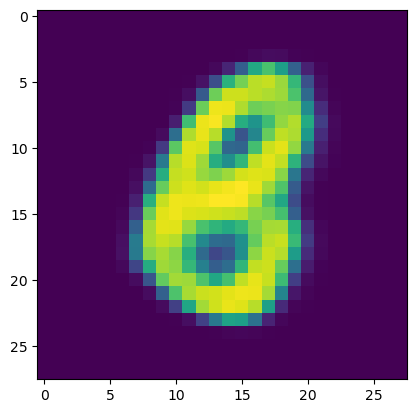

In [8]:
plt.imshow(outimg)

In [23]:
len(train_loader.dataset)

60000

In [24]:
len(test_loader.dataset)

10000